This demo shows how MulitQC intermediate format based on parquet can be used to explore data across multiple runs.

First, let's run MultiQC a bunch of times.

In [ ]:
import multiqc
from multiqc import ClConfig

for i, path in enumerate([
    "/Users/vlad/Seqera/multiqc_heavy_examples/Petropoulus_2016/fastqc/ERX112088*",
    "/Users/vlad/Seqera/multiqc_heavy_examples/Petropoulus_2016/fastqc/ERX112089*",
    "/Users/vlad/Seqera/multiqc_heavy_examples/Petropoulus_2016/fastqc/ERX112090*",
    "/Users/vlad/Seqera/multiqc_heavy_examples/Petropoulus_2016/fastqc/ERX112091*",
    "/Users/vlad/Seqera/multiqc_heavy_examples/Petropoulus_2016/fastqc/ERX112092*",
]):
    multiqc.run(
        path,
        cfg=ClConfig(
            output_dir=f"/Users/vlad/tmp/combine_tests/run{i + 1}",
            force=True,
            strict=True,
        )
    )

In [2]:
%ls /Users/vlad/tmp/combine_tests/run*/multiqc_data/*.parquet

/Users/vlad/tmp/combine_tests/run1/multiqc_data/multiqc.parquet
/Users/vlad/tmp/combine_tests/run1plus2/multiqc_data/multiqc.parquet
/Users/vlad/tmp/combine_tests/run2/multiqc_data/multiqc.parquet
/Users/vlad/tmp/combine_tests/run3/multiqc_data/multiqc.parquet
/Users/vlad/tmp/combine_tests/run4/multiqc_data/multiqc.parquet
/Users/vlad/tmp/combine_tests/run5/multiqc_data/multiqc.parquet


We can run MultiQC on the outputs of those runs even without the access to the original data:

In [ ]:
multiqc.run(
    "/Users/vlad/tmp/combine_tests/run1/multiqc_data/multiqc.parquet",
    "/Users/vlad/tmp/combine_tests/run2/multiqc_data/multiqc.parquet",
    cfg=ClConfig(
        output_dir="/Users/vlad/tmp/combine_tests/run1plus2",
        force=True,
    )
)

However, a more interesting usecase is to make use of the columnar nature of the parquet file format to e.g. explore metric trends over time. We would use duckdb to query parquet. They can be as well located e.g. as form of a data lake on an s3 bucket.

In [4]:
import pandas as pd
import duckdb

con = duckdb.connect()
df = con.execute("""
    SELECT 
        sample_name, 
        val_raw as total_sequences,
        timestamp
    FROM '/Users/vlad/tmp/combine_tests/run[1-5]/multiqc_data/multiqc.parquet'
    WHERE metric_name = 'total_sequences'
    ORDER BY timestamp, val_raw
""").df()

print(df[['timestamp', 'sample_name', 'total_sequences']])

                           timestamp sample_name total_sequences
0   2025-04-18T17:52:36.266793+02:00  ERX1120886       2286825.0
1   2025-04-18T17:52:36.266793+02:00  ERX1120889       2383241.0
2   2025-04-18T17:52:36.266793+02:00  ERX1120888       4886841.0
3   2025-04-18T17:52:36.266793+02:00  ERX1120885       4941064.0
4   2025-04-18T17:52:36.266793+02:00  ERX1120887       5453345.0
5   2025-04-18T17:52:37.223373+02:00  ERX1120893      12015105.0
6   2025-04-18T17:52:37.223373+02:00  ERX1120890       3857107.0
7   2025-04-18T17:52:37.223373+02:00  ERX1120891       4788791.0
8   2025-04-18T17:52:37.223373+02:00  ERX1120896       5547967.0
9   2025-04-18T17:52:37.223373+02:00  ERX1120894       6603904.0
10  2025-04-18T17:52:37.223373+02:00  ERX1120899       6849883.0
11  2025-04-18T17:52:37.223373+02:00  ERX1120898       7907728.0
12  2025-04-18T17:52:37.223373+02:00  ERX1120897       8527930.0
13  2025-04-18T17:52:37.223373+02:00  ERX1120895       8948672.0
14  2025-04-18T17:52:37.2

Let's start with a histogram of total sequences

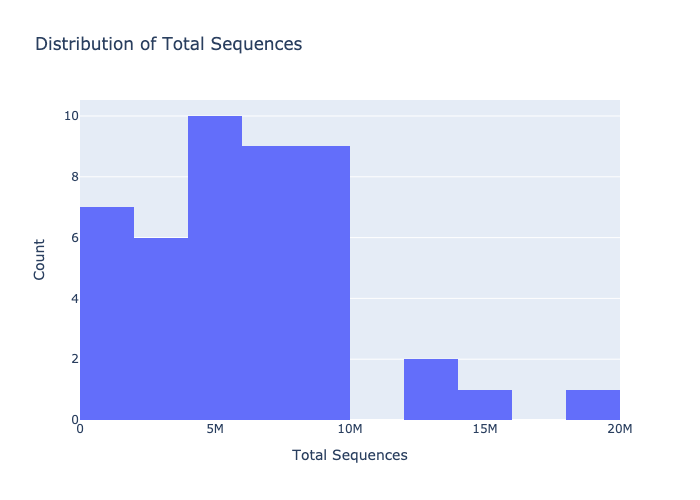

In [7]:
import plotly.graph_objs as go

data = [
    go.Histogram(
        x=df["total_sequences"].map(lambda x: float(x)),
        name="Total Sequences",
        nbinsx=10,
    )
]

layout = {
    "title": "Distribution of Total Sequences",
    "xaxis": {"title": "Total Sequences"},
    "yaxis": {"title": "Count"}
}

go.Figure(data=data, layout=layout).show(renderer="png")

Now let's plot a timeline

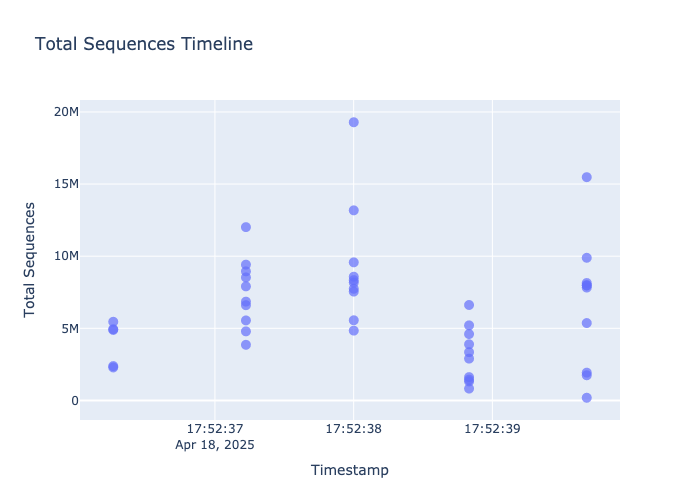

In [8]:
# Ensure timestamps are in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by timestamp
df = df.sort_values("timestamp")

data = [
    go.Scatter(
        x=df["timestamp"],
        y=df["total_sequences"].map(lambda x: float(x)),
        mode="markers",
        name="Total Sequences",
        marker=dict(
            size=10,
            opacity=0.7
        )
    )
]

layout = {
    "title": "Total Sequences Timeline",
    "xaxis": {"title": "Timestamp"},
    "yaxis": {"title": "Total Sequences"},
    "hovermode": "closest"
}

go.Figure(data=data, layout=layout).show(renderer="png")

In [9]:
import pandas as pd
pf = '/Users/vlad/git/MultiQC/playground/runs/run_SAMPLE_multiqc_report_data/multiqc.parquet'
# pf = '/var/folders/zn/9rrn2wv97lncdpqrp79p5rpm0000gn/T/tmpvtgczdba/multiqc_data/multiqc.parquet'
df = pd.read_parquet(pf)
df.head(100)

,anchor,dt_anchor,section_key,sample_name,metric_name,metric_idx,val_raw,val_raw_type,val_mod,val_mod_type,...,plot_type,_pconfig,timestamp,type,modules,data_sources,creation_date,config,plot_data,multiqc_version
0,samtools-flagstat-dp,samtools-flagstat-dp_table,samtools-flagstat-dp_table,SAMPLE1_PE,flagstat_total,0.0,48045,int,48.045,float,...,violin plot,"{""id"": ""samtools-flagstat-dp"", ""title"": ""Samto...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
1,samtools-flagstat-dp,samtools-flagstat-dp_table,samtools-flagstat-dp_table,SAMPLE1_PE,total_passed,0.0,48045,int,48.045,float,...,violin plot,"{""id"": ""samtools-flagstat-dp"", ""title"": ""Samto...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
2,samtools-flagstat-dp,samtools-flagstat-dp_table,samtools-flagstat-dp_table,SAMPLE1_PE,mapped_passed,0.0,48045,int,48.045,float,...,violin plot,"{""id"": ""samtools-flagstat-dp"", ""title"": ""Samto...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
3,samtools-flagstat-dp,samtools-flagstat-dp_table,samtools-flagstat-dp_table,SAMPLE1_PE,duplicates_passed,0.0,0,int,0.0,float,...,violin plot,"{""id"": ""samtools-flagstat-dp"", ""title"": ""Samto...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
4,samtools-flagstat-dp,samtools-flagstat-dp_table,samtools-flagstat-dp_table,SAMPLE1_PE,paired in sequencing_passed,0.0,48045,int,48.045,float,...,violin plot,"{""id"": ""samtools-flagstat-dp"", ""title"": ""Samto...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,general_stats_table,general_stats_table_table,samtools_bowtie2,SAMPLE2_PE,mapped_passed_pct,0.0,100.0,float,100.0,float,...,violin plot,"{""id"": ""general_stats_table"", ""title"": ""Genera...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
66,general_stats_table,general_stats_table_table,samtools_bowtie2,SAMPLE3_SE,flagstat_total,0.0,46278,int,46.278,float,...,violin plot,"{""id"": ""general_stats_table"", ""title"": ""Genera...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
67,general_stats_table,general_stats_table_table,samtools_bowtie2,SAMPLE3_SE,mapped_passed,0.0,46278,int,46.278,float,...,violin plot,"{""id"": ""general_stats_table"", ""title"": ""Genera...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
68,general_stats_table,general_stats_table_table,samtools_bowtie2,SAMPLE3_SE,mapped_passed_pct,0.0,100.0,float,100.0,float,...,violin plot,"{""id"": ""general_stats_table"", ""title"": ""Genera...",2025-04-18T13:31:26.054219+02:00,None,None,None,None,None,None,None
